In [932]:
import sys
sys.path.insert(0, "../")

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import flax.linen as nn
from matplotlib import pyplot as plt
import module.util as util
import optax

## Diffusion Modelling

As introduced before, the score function is very handy to describe and learn probability distributions. To pass over to diffusion models, we don't directly learn $p(x)$ but we introduce a time dependent distribution $p(x, t)$. We require that for $t = 0$ the two coincide, meaning $p(x, 0) = p(x)$. We will define this family of distributions via a stochastic differential equation. Here we chose the Ohrnstein-Uhlenbeck process:
$$
dx = -\alpha x dt + \sigma dW
$$
This gives rise to the following time-dependent random variable
$$
x_t = x_0 e^{-\alpha t} + \frac{\sigma}{\sqrt{2\alpha}}\sqrt{1 - e^{-2\alpha t}}\, \xi_t
$$
where $\xi_t$ are standard normals. We can easily write the conditional density $p(x_t | x_0)$
$$
p(x_t | x_0) = \frac{1}{Z}\exp[-\frac{\alpha}{\sigma^2}\frac{||x_t - x_0 e^{-\alpha t}||^2}{1-e^{-2\alpha t}}]
$$
We can compute also the conditional score function
$$
\nabla_{x_t}\,\log p(x_t | x_0) = \frac{2\alpha}{\sigma^2} \frac{x_t - x_0 e^{-\alpha t}}{e^{-2\alpha t} - 1}
$$

#### Why?
When dealing with high-dimensional data-spaces (e.g. the space of possible 256x256 grayscale images $\Chi = [0, 1]^{65536}$), the distribution of real-world images $p(x)$ is often accused of
$$
\mu(\mathrm{supp}\, p(x)) = 0
$$
taking $\mu$ to be the Borell measure on $\Chi$. This is also called the manifold hypothesis - The hypothesis is obviously wrong, which becomes apparent when considering simple quantum mechanics. 
$$
\Delta E \Delta t \ge \hbar
$$
When measuring for example the intensity of a pixel, one would in theory have to wait an infinite amount of time to even hope for a precise measurement. So the distribution will in practise have a support of measure greater than zero. Still, there can be large areas where the distribution is a flat zero.
This means, that the score function in those areas would be equal to zero. If we now start our Langevin-sampling outside of the support of $p(x)$, we would not get any feedback from our score function $s$ about where to go. We are lost in a big data space. 

Also, as we minimise a $L^2(\Chi, \mathcal{F}, p\,\mu)$-norm in the loss function and the areas described before are null-sets therein, our predicted score function will not be meaningful in those areas. To mitigate this, we convolve our data distribution with increasing noise levels to smoothen it out until it just becomes gaussian noise. This is exactly what the above stochastic differential equation does. 

If we now learn the score function $\nabla_{x_t} \log p(x_t)$ for all times, we can follow a different stochastic differential equation which we will call the reverse differential equation. It is given by
$$
du = [\alpha x + \sigma^2\nabla \log p(u, T - t)] dt + \sigma dW
$$
Note, that this equation needs the scores of the forward process. This process is interesting, as a solution $q(u, t)$ is obtained as:
$$
q(u, t) = p(u, T - t)
$$
This process reverses the dynamics of the forward process. Thus starting from noise, we transform the noise into data. We have worked around the support problem, as initially $q(u, 0) = p(u, T)$ is just a simple noise whose support coincides with the entire space. We can now numerically solve this stochastic differential equation to obtain new samples of the data distribution.

## Loss Function
Recalling the loss function of the time-independent case, we can write it down seperately for every $t$
$$
\begin{align}
L_t[s] = \int_\Chi ||s(x) - \nabla \log p(x, t) ||^2 p(x, t)\,d\mu
\end{align}
$$
As opposed to before, we will now want to parametrise the entrie family of score functions with a neural network $s(x, t)$. We then set our new loss function to be the time average of the above
$$
\begin{align}
L[s] = \int_{[0, T]} \rho(t) \int_\Chi ||s(x, t) - \nabla \log p(x, t) ||^2 p(x, t)\,d\mu \,dt
\end{align}
$$
After minimising this and obtaining an estimate of the actual time dependent scores, we can run the reverse SDE to produce samples.

## Numerics
Again the above loss function is in practise not computable as we don't have an expression for $p(x, t)$. We do however have an expression for $p(x_t | x_0)$. Slightly massaging the above loss function, we can turn it into a nicer expression which we can evaluate. The following loss function only differs by a constant from the one presented before, so the $\argmin_\theta$ wil stay the same
$$
L[s] = \int_{[0, T]} \rho(t) \int_\Chi \int_\Chi ||s(x_t, t) - \nabla_{x_t} \log p(x_t | x_0) ||^2 p(x_t, x_0)\,dx_t\,dx_0\,dt
$$
The integrals can be evaluated via sampling.

In [933]:
key = jax.random.PRNGKey(0)

In [934]:
space_dim = 2

def get_samples(key, N = 1000):
    z = jax.random.uniform(key, (N,))*2
    key, _ = jax.random.split(key)
    x1 = jax.random.normal(key, (N,))*0.1 + z - 1 
    key, _ = jax.random.split(key)
    x2 = jax.random.normal(key, (N,))*0.1 +jnp.sin(jnp.pi*z)

    return jnp.stack((x1, x2), axis = -1)


In [981]:
#
# Diffusion Parameters
#
alpha = 0.1
sigma = jnp.sqrt(0.2)

var_final = sigma**2/2/alpha
T = 1/alpha/10
print("final variance =", var_final)
print("final time = ", T)

def calc_grad_log_cond(x_0, x_t, t):
    res = 2*alpha/sigma**2 / (jnp.exp(-2*alpha*t) - 1) * (x_t - x_0*jnp.exp(-alpha*t))
    return res

final variance = 0.99999994
final time =  1.0


(-1.5, 1.5)

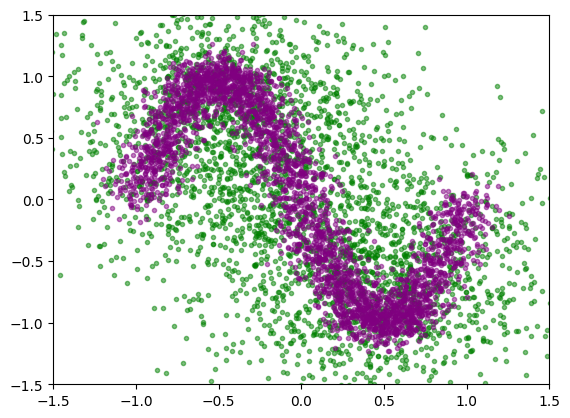

In [986]:
N = 3000
t = T

key, _ = jax.random.split(key)
x0 = get_samples(key, N)
key, _ = jax.random.split(key)
xi = jax.random.normal(key, (N, space_dim))
xt = x0 * jnp.exp(-alpha*t) + sigma/jnp.sqrt(2*alpha)*jnp.sqrt(1-jnp.exp(-2*alpha*t))*xi

xs = jnp.linspace(-2, 2, num = 20)
ys = jnp.linspace(-1, 1, num = 20)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

plt.scatter(xt[:,0], xt[:,1], color = "green", alpha = 0.5, marker = ".")
plt.scatter(x0[:,0], x0[:,1], color = "purple", alpha = 0.5, marker = ".")

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

### Define Score Model

In [1066]:
act = lambda x: nn.softplus(x)

class ScoreModel(nn.Module):
  @nn.compact
  def __call__(self, x, t):

    time_embed_1 = nn.Dense(64)(t)
    time_embed_1 = act(time_embed_1)
    time_embed_2 = nn.Dense(64)(time_embed_1)
    time_embed_2 = act(time_embed_1)

    space_embed =  nn.Dense(64)(x)

    stacked = jnp.concatenate((space_embed, time_embed_1), axis = -1)
    z = nn.Dense(64)(stacked)
    z = act(z) + space_embed

    stacked = jnp.concatenate((z, time_embed_2), axis = -1)
    y = nn.Dense(64)(z)
    y = act(y)

    out = nn.Dense(2)(y)

    return out

### Optimisation

In [1067]:
model = ScoreModel()
param = model.init(key, jnp.empty((space_dim,)), jnp.empty((1,)))

In [1068]:
# @jax.jit
# def calc_loss(param, x0, xt, t):
#     eval = model.apply(param, xt, t)
#     cond_scores = calc_grad_log_cond(x0, xt, t)

#     diff = jnp.sum(eval**2, axis = -1) - 2*jnp.sum(eval * cond_scores, axis = -1)

#     return jnp.mean(diff)

@jax.jit
def calc_loss(param, samples, t, w):
    eval = model.apply(param, samples, t)
    a = jnp.sum(eval ** 2, axis = -1)
    c = 2*jnp.sum(w*jax.jvp(model.apply, (param, samples, t), (util.t_zeros_like(param), w, jnp.zeros_like(t)))[1], axis = -1)

    return jnp.mean(a + c)


@jax.jit
def grad_loss(param, samples, t, w):
    l = lambda param: calc_loss(param, samples, t, w)
    grad = jax.vjp(l, param)[1](jnp.array(1.))
    return grad[0]

In [1069]:
losses = []
param = model.init(key, jnp.empty((space_dim,)), jnp.empty((1,)))
optimiser = optax.adam(1e-2)
opt_state = optimiser.init(param)

In [1086]:
optimiser = optax.adam(1e-3)
opt_state = optimiser.init(param)

In [1087]:
N = 3000
for i in range(1000):
    key, _ = jax.random.split(key)
    x0 = get_samples(key, N)
    key, _ = jax.random.split(key)
    xi = jax.random.normal(key, (N, space_dim))
    key, _ = jax.random.split(key)
    t = jax.random.uniform(key, (N, 1)) * T
    xt = x0 * jnp.exp(-alpha*t) + sigma/jnp.sqrt(2*alpha)*jnp.sqrt(1-jnp.exp(-2*alpha*t))*xi
    key, _ = jax.random.split(key)
    w = jax.random.normal(key, (N, space_dim))

    loss = calc_loss(param, xt, t, w)
    losses.append(loss)
    grad = grad_loss(param, xt, t, w)

    updates, opt_state = optimiser.update(grad, opt_state)
    param = optax.apply_updates(param, updates)

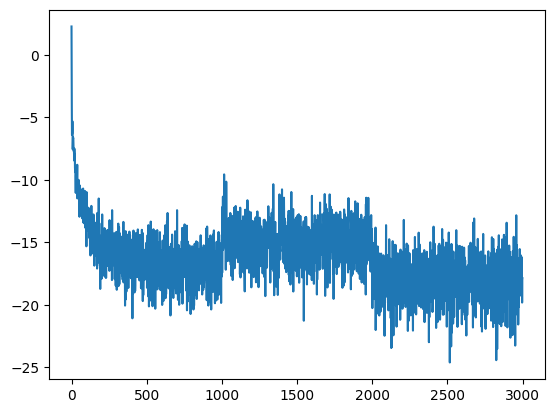

In [1088]:
plt.plot(losses)

(-2.0, 2.0)

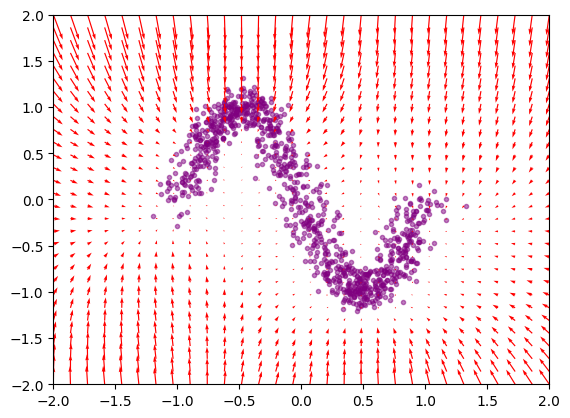

In [1089]:
t = 0
N = 1000

key, _ = jax.random.split(key)
x0 = get_samples(key, N)
key, _ = jax.random.split(key)
xi = jax.random.normal(key, (N, space_dim))
xt = x0 * jnp.exp(-alpha*t) + sigma/jnp.sqrt(2*alpha)*jnp.sqrt(1-jnp.exp(-2*alpha*t))*xi
xs = jnp.linspace(-2, 2, num = 30)
ys = jnp.linspace(-2, 2, num = 30)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

score_approx = model.apply(param, coord, jnp.ones((30, 30, 1)) * t)

plt.scatter(xt[:,0], xt[:,1], color = "purple", alpha = 0.5, marker = ".")
plt.quiver(xx, yy, score_approx[...,0], score_approx[...,1], color = "r")
plt.xlim(-2, 2)
plt.ylim(-2, 2)

## Sample using the Score-Function
After obtaining the score function for all times, we run a special backwards SDE whose distribution evolves exactly backwards in time compared to the forward diffusion process.
$$
dx = [\alpha x + \sigma^2 \nabla \log p(x, T - t)]dt + \sigma dW
$$
Euler-Marujana discretising this leads to:
$$
x_{t+\epsilon} = (1 + \alpha \epsilon)x_{\epsilon} + \epsilon \sigma^2 \nabla \log p(x, T - t) + \sigma\sqrt{\epsilon}\,\xi_t
$$
where $\epsilon$ is the integration time-step and $\xi_t$ are independent standard normal gaussians.

In [1090]:
N = 3000

x = jax.random.normal(key, (N, space_dim)) * sigma/jnp.sqrt(2*alpha) * (1 - 1/2*jnp.exp(-2))
epsilon = 0.01
t = 0

In [1091]:
while t + epsilon < T:
    key, _ = jax.random.split(key)

    t_eval = max(T - t, 0)
    dx = (alpha * x + sigma ** 2 * model.apply(param, x, jnp.ones((N, 1))*t_eval))*epsilon + sigma * jnp.sqrt(epsilon) * jax.random.normal(key, (N, space_dim))
    x = x + dx
    t = t + epsilon

(-2.0, 2.0)

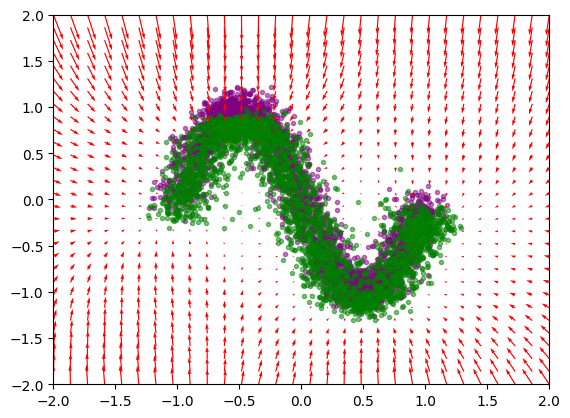

In [1092]:
key, _ = jax.random.split(key)
x0 = get_samples(key, N)

xs = jnp.linspace(-2, 2, num = 30)
ys = jnp.linspace(-2, 2, num = 30)
xx, yy = jnp.meshgrid(xs, ys)
coord = jnp.stack((xx, yy), axis = -1)

score_approx = model.apply(param, coord, jnp.ones((30, 30, 1)) * (T - t))

plt.scatter(x0[:,0], x0[:,1], color = "purple", alpha = 0.5, marker = ".")
plt.scatter(x[:,0], x[:,1], color = "green", alpha = 0.5, marker = ".")
plt.quiver(xx, yy, score_approx[...,0], score_approx[...,1], color = "r")
plt.xlim(-2, 2)
plt.ylim(-2, 2)

In [1093]:
# sausage